# Block-Silhouette Analysis for CogSci 2020

## Import and set up directories

In [667]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

import analysis_helpers as h
importlib.reload(h)
Z = h.save_bis(df,csv_dir,iteration_name)

Saved BIS dataframe out!


In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load Data

In [3]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [4]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

51 participants total


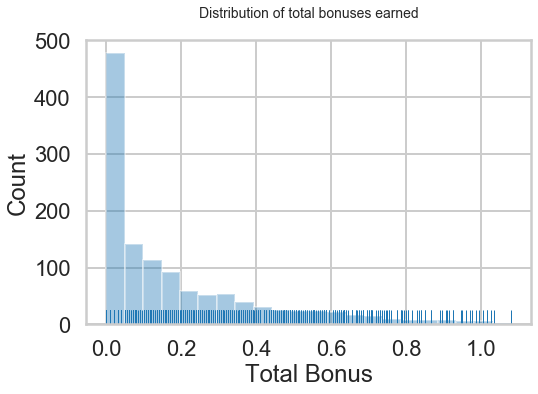

In [5]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['score'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

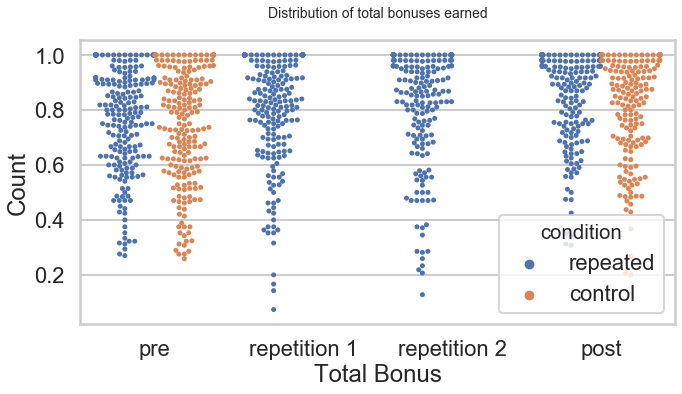

In [140]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'phase_extended',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
                  dodge=True,
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()


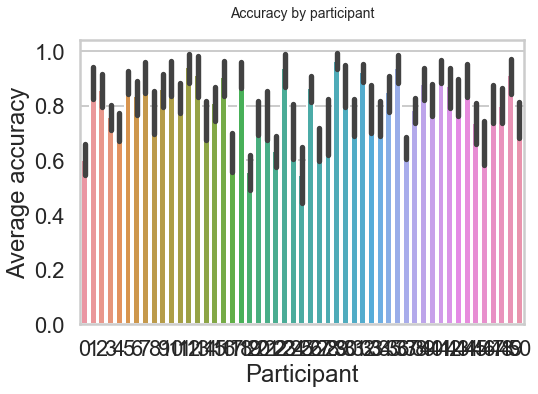

In [7]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'gameID',
                y = 'rawF1DiscreteScore',
                #hue = 'phase',
                #hue = 'repetition',
                data = df)
plt.ylabel('Average accuracy')
plt.xlabel('Participant')
plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Accuracy by participant\n',{'fontsize': 14})
plt.tight_layout()

ValueError: cannot convert float NaN to integer

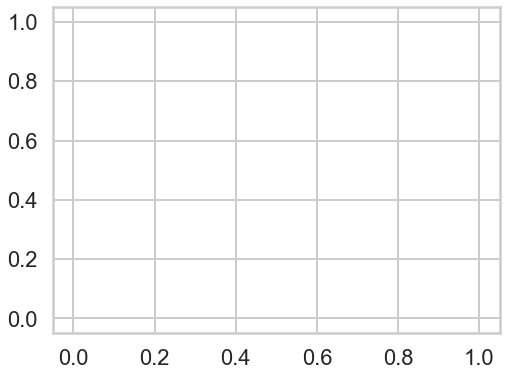

In [10]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['rawF1DiscreteScore'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.title('Distribution of Discrete F1 Scores\n',{'fontsize': 14})
plt.tight_layout()


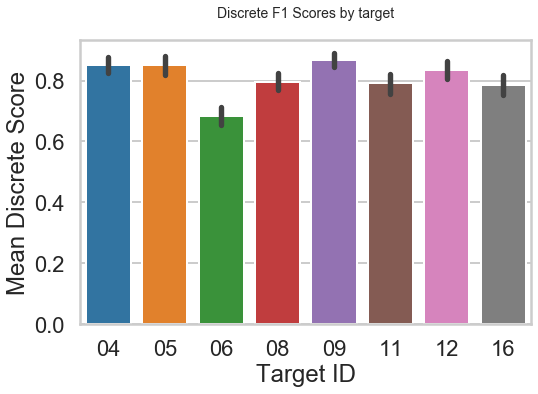

In [11]:
names = df.targetName.unique()
names.sort()
structure_numbers = list(map(lambda x: x[-2:],names))

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'targetName',
                y = 'rawF1DiscreteScore',
                order = names,
                data = df)
plt.ylabel('Mean Discrete Score')
plt.xlabel('Target ID')
plt.xticks(np.arange(len(names)),structure_numbers)
plt.title('Discrete F1 Scores by target\n',{'fontsize': 14})
plt.tight_layout()

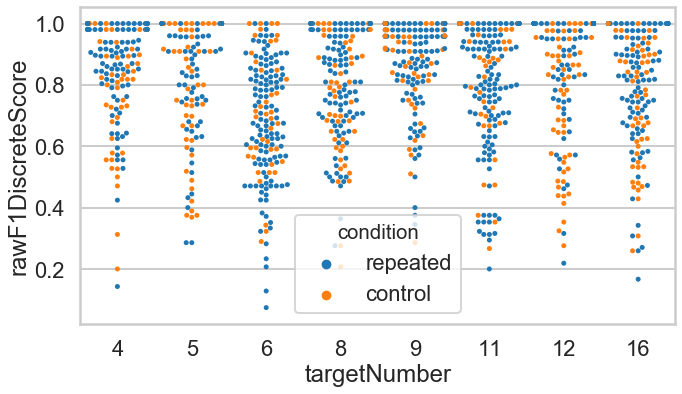

In [12]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'targetNumber',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
            data = df)
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.tight_layout()

In [13]:
# exclude outliers with low mean score
remove_outliers = False

if remove_outliers:

    threshold = 0.7

    df_means = df.groupby(by=['gameID'])['rawF1DiscreteScore'].apply(np.mean).reset_index()
    low_scores = df_means[df_means.rawF1DiscreteScore< threshold]['gameID'] 
    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score <'+str(threshold)+' and full set of trials')



In [14]:
# Exclude outliers with low total bonus

remove_outliers = False

if remove_outliers:

    low_scores = df[(df.trialNum == (num_trials-1)) & (df.score == 0)]['gameID'] # people who achieved zero bonus


    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score > 0 and full set of trials')


In [15]:
if False:
    importlib.reload(drawing)
    drawing.draw_all_trials(df, figsize=(20,80))

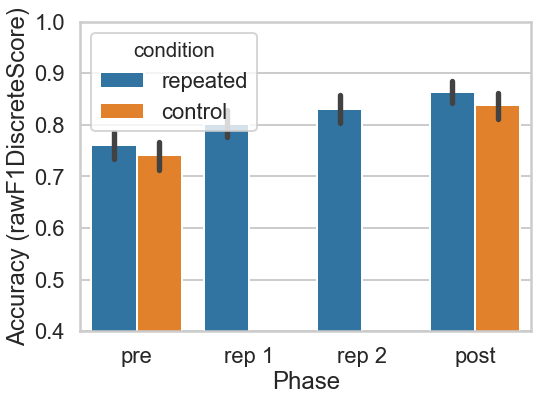

In [16]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()


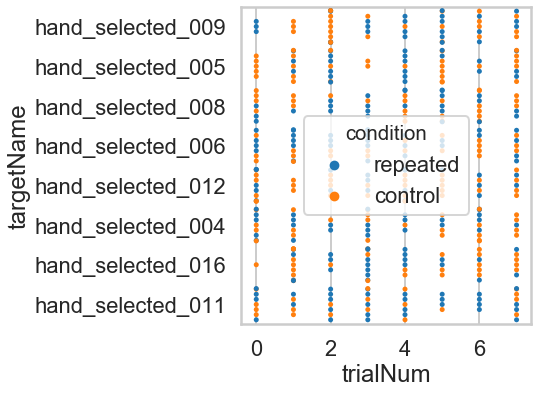

In [17]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(y='targetName', 
                x='trialNum', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.tight_layout()


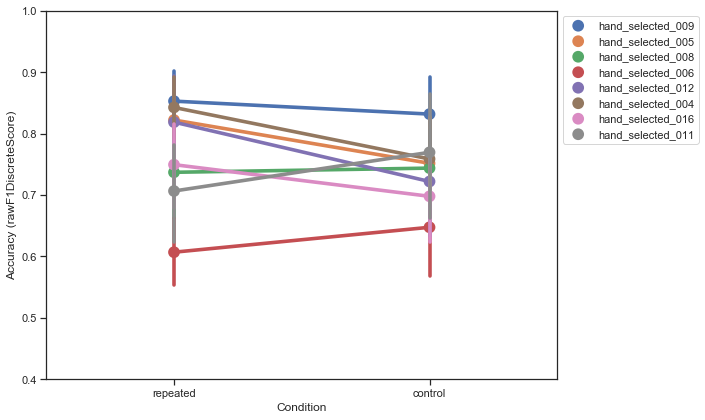

In [18]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='targetName', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Condition')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

/Users/will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


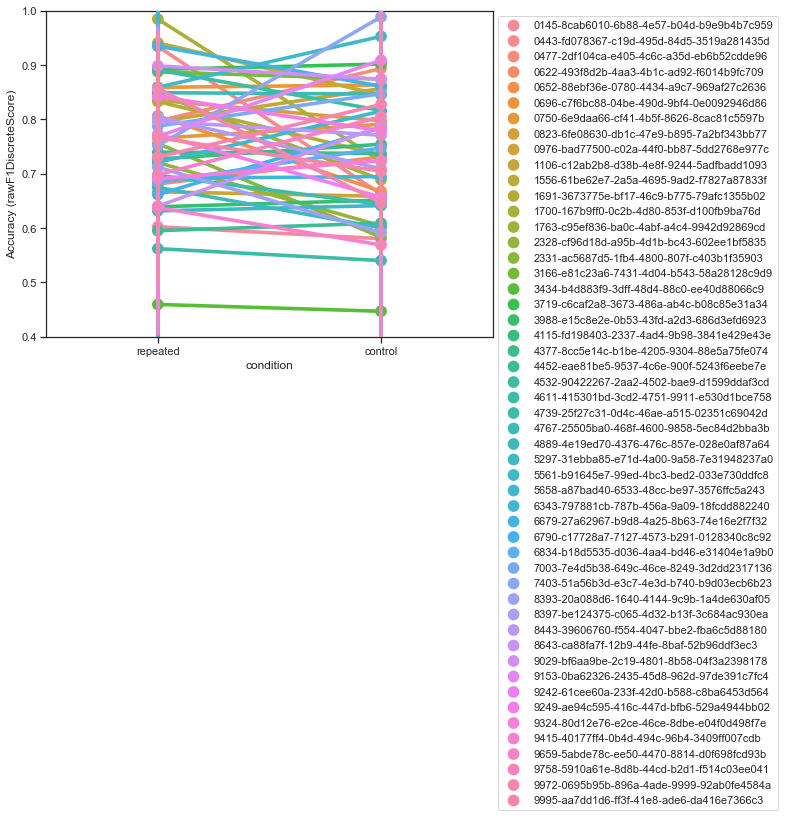

In [19]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='gameID', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

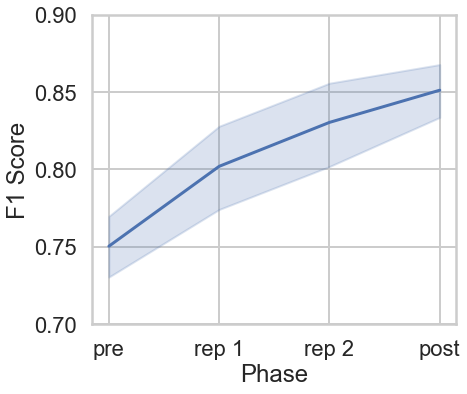

In [678]:
# Accuracy by phase
fig = plt.figure(figsize=(7,6))
sns.set_context('poster')
sns.set(font_scale=5)
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                #hue='condition',
                #style='condition',
                #style_order=['repeated','control'],
                #kind='point', 
                #legend=False,]
                #data=df[~df.blockFell]);
                #data=df[~df.blockFell]);
                data=df)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
c.set(xlabel='Phase', ylabel='F1 Score')
#plt.yticks(np.linspace(.4,1,5))
plt.ylim((0.7,0.9))
plt.tight_layout()

'Phase'

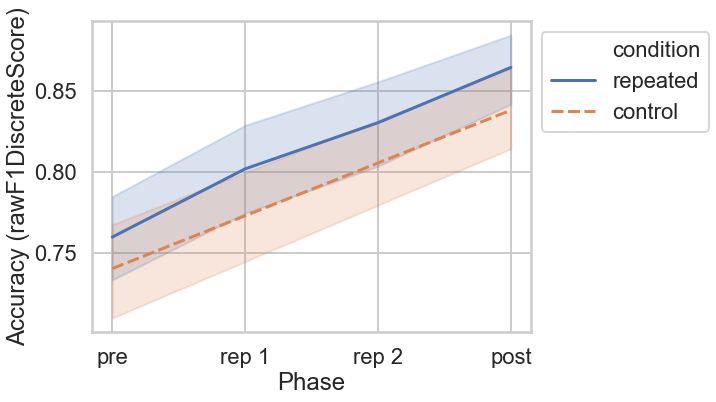

In [122]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,]
                #data=df[~df.blockFell]);
                #data=df[~df.blockFell]);
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(.4,1,5))
#plt.ylim((0.65,0.95))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

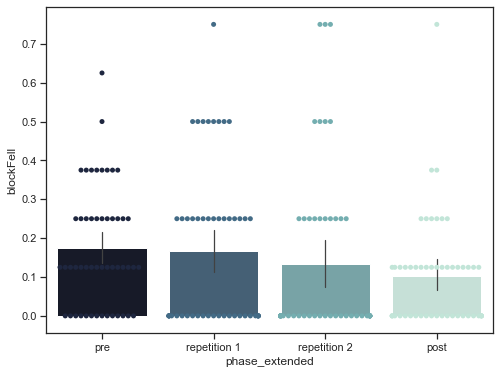

In [65]:
#Mean number of trials with blocks falling

df_block_fell_means = df.groupby(by=['gameID','phase_extended'])['blockFell'].agg(np.mean).reset_index()


#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.barplot(x='phase_extended', 
                y='blockFell', 
                order=['pre','repetition 1','repetition 2','post'],
                palette="ch:r=-.3,d=.1_r",
                data = df_block_fell_means)
c = sns.swarmplot(x='phase_extended', 
                    y='blockFell',
                    order=['pre','repetition 1','repetition 2','post'],
                    dodge=True,
                    palette="ch:r=-.3,d=.15_r",
                    data = df_block_fell_means)

In [70]:
df_block_fell_means['blockFell'].value_counts()

0.000    99
0.250    42
0.125    34
0.500    13
0.375    10
0.750     5
0.625     1
Name: blockFell, dtype: int64

### Exploration into why F1 seems higher for repeated

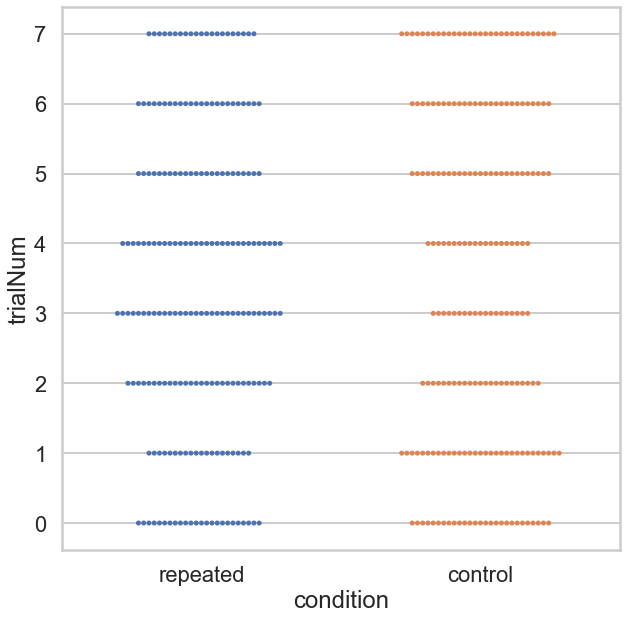

In [21]:
# Build Time over trials
fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.swarmplot(x='condition',
                y='trialNum', 
                dodge=True,
                linewidth=0,
                #palette="ch:r=-.3,d=.1_r",
                #kind='point', 
                data=df[df.phase=='pre'])

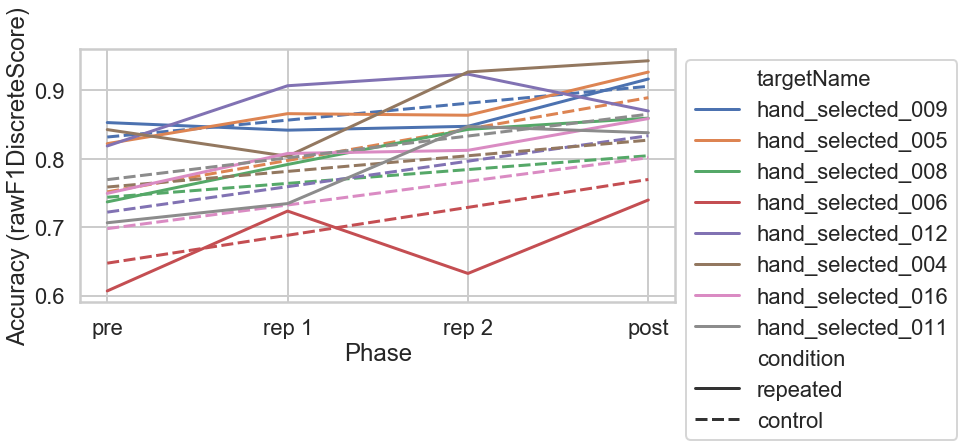

In [22]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='targetName',
                style='condition',
                ci = None,
                #style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

<Figure size 720x432 with 0 Axes>

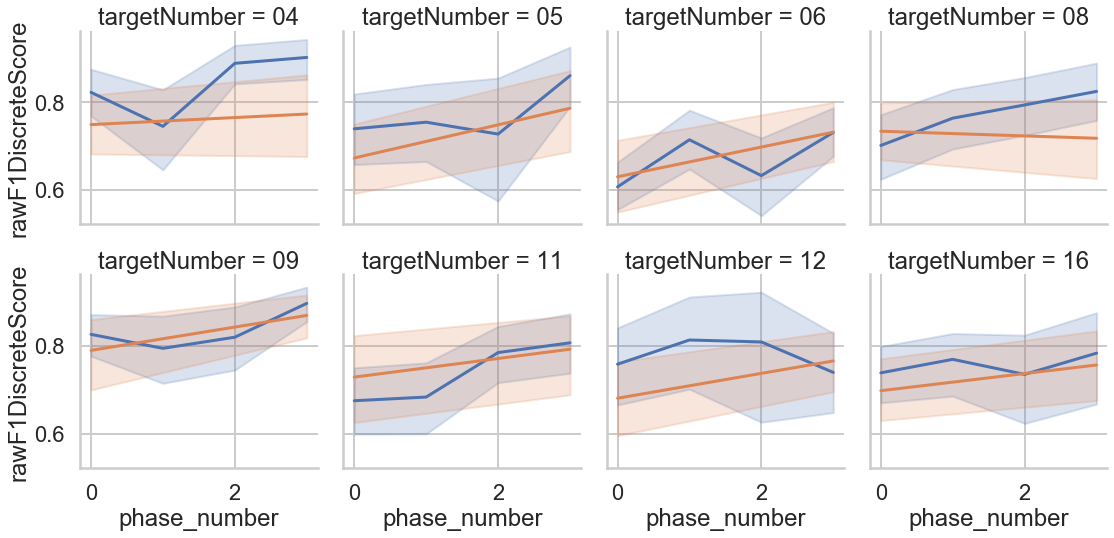

In [120]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df, col="targetNumber", col_wrap=4, height=4, hue="condition")
g.map(sns.lineplot, "phase_number", "rawF1DiscreteScore");

<Figure size 720x432 with 0 Axes>

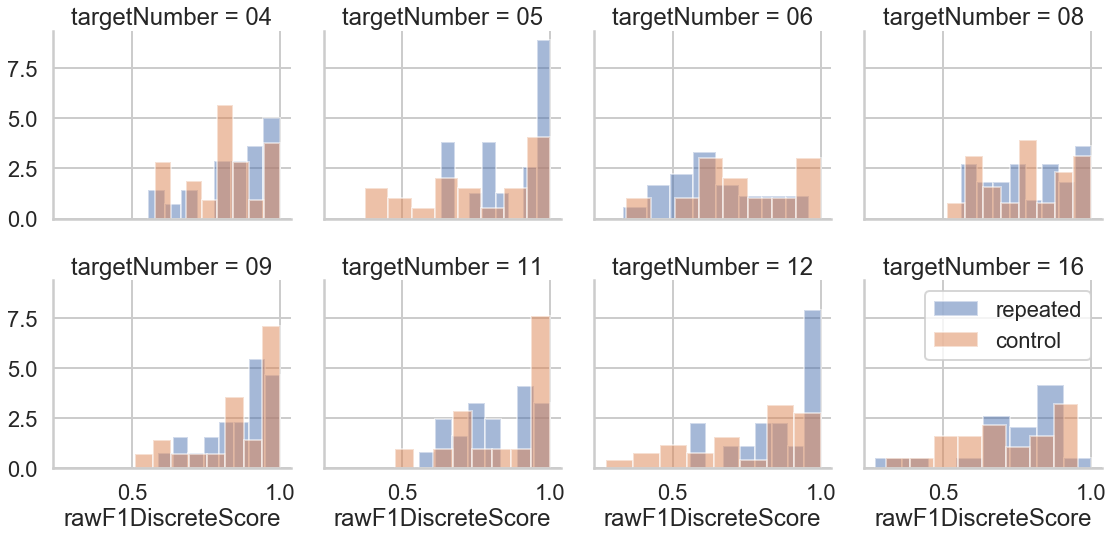

In [119]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df[(~df.blockFell) & (df.phase.isin(['pre']))], col="targetNumber", col_wrap=4, height=4, hue="condition")
#g.map(sns.lineplot, "phase", "rawF1DiscreteScore");
g.map(plt.hist, "rawF1DiscreteScore", density=True, bins=8, alpha=0.5)
plt.legend(bbox_to_anchor=(1.0,1))

In [99]:
# Number of blocks

#df[df.condition=='control']['targetName'].value_counts()
df[df.condition=='repeated']['targetName'].value_counts()

hand_selected_011    124
hand_selected_006    120
hand_selected_004    104
hand_selected_009    104
hand_selected_008    100
hand_selected_016     96
hand_selected_005     88
hand_selected_012     80
Name: targetName, dtype: int64

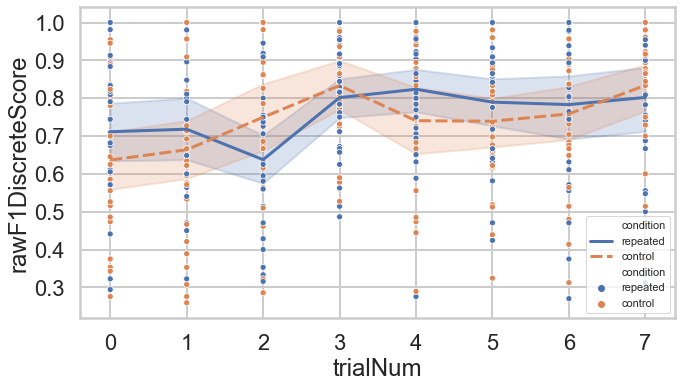

In [27]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df);

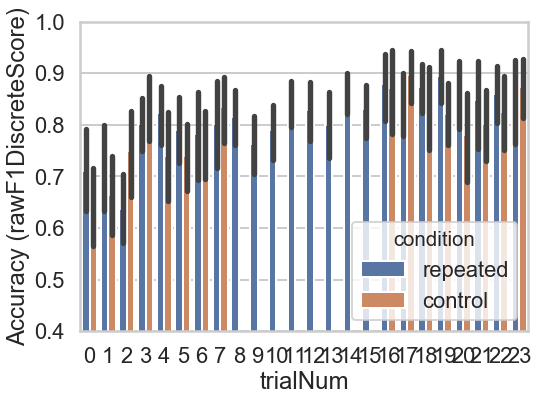

In [28]:
fig = plt.figure(figsize=(8,6))
sns.set(style="ticks", rc={"lines.linewidth": 0.5})
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()


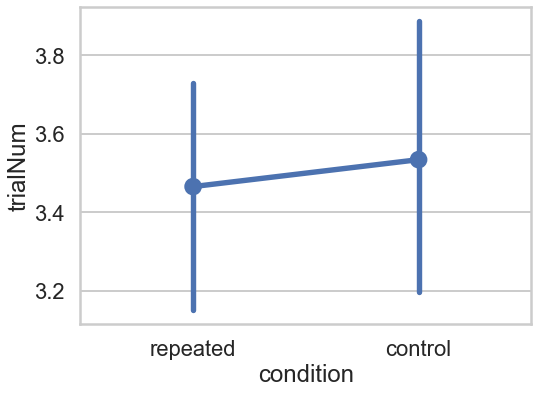

In [29]:
#double check that repeated condition isn't coming after control

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='condition', 
                y='trialNum', 
                #hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

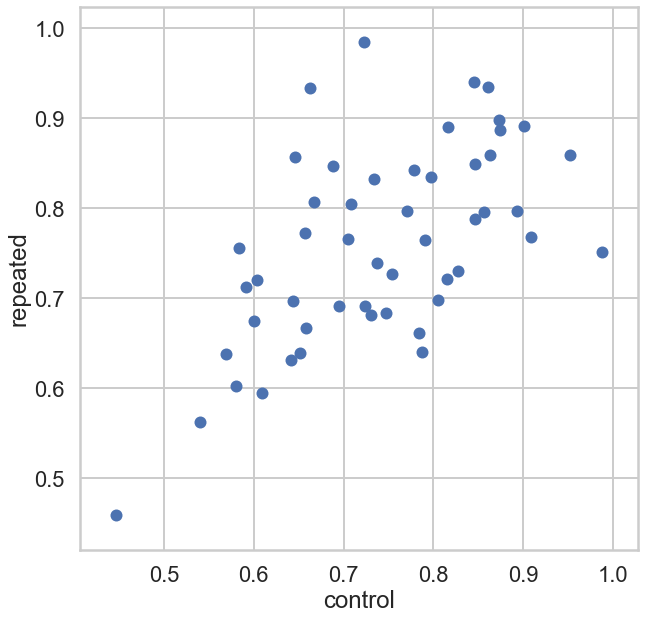

In [30]:
df_pre = df[df.phase=='pre']
df_grouped_pre = df_pre.groupby(by=['gameID','condition'])['rawF1DiscreteScore'].apply(np.mean).reset_index()

df_grouped_pre_wide = df_grouped_pre.pivot(index='gameID', columns='condition',values='rawF1DiscreteScore')


# Build Time over trials
fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='control', 
                    y='repeated', 
                    #hue='repeated',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    #palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df_grouped_pre_wide)


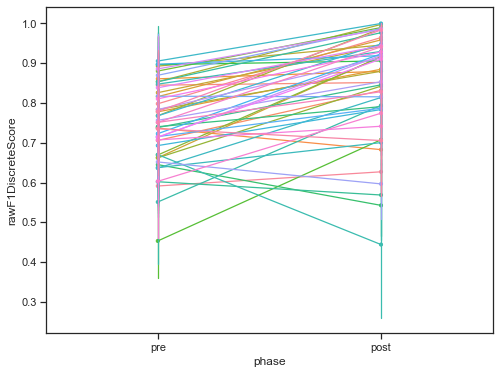

In [32]:
# Individual accuracy, pre- vs. post-

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)


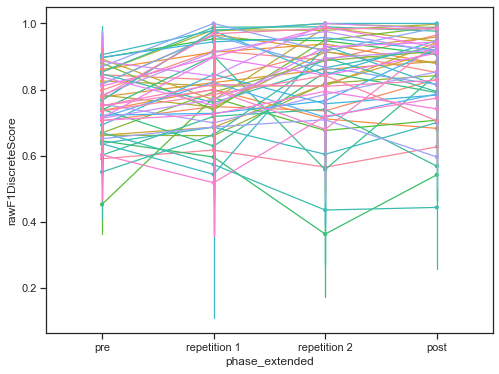

In [33]:
# Individual accuracy, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

## Number of blocks

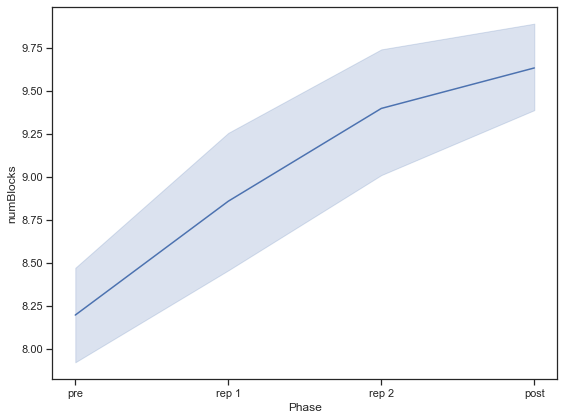

In [527]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                #hue='condition',
                #style='condition',
                #style_order=['repeated','control'],
                #data=df[df.blockFell == False]);
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

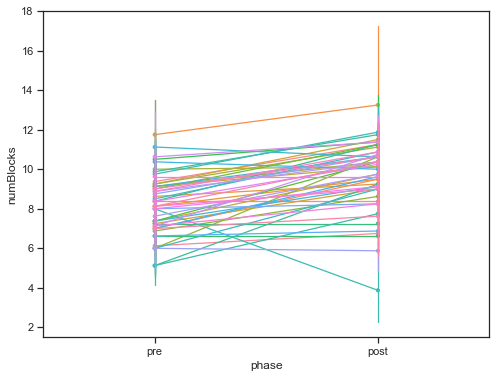

In [523]:
# Individual block use pre- and post- 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

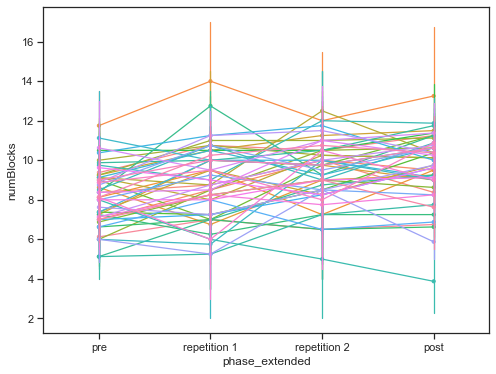

In [37]:
# Individual block use, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

### Area covered

In [ ]:
# add area over time
world_maps = df['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
df['area_covered'] = world_maps.apply(np.sum)

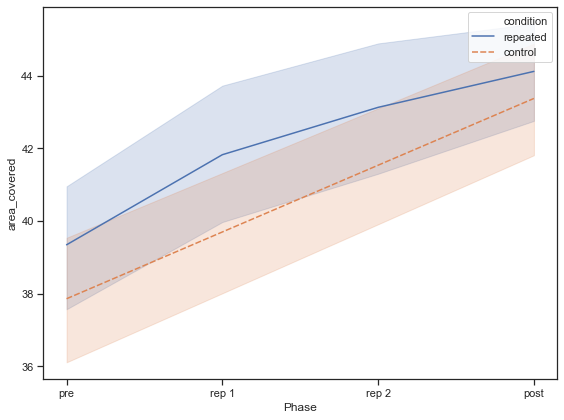

In [96]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
c = sns.lineplot(x='phase_number', 
                y='area_covered', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #data=df[df.blockFell == False]);
                data=df);
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

## Build Time

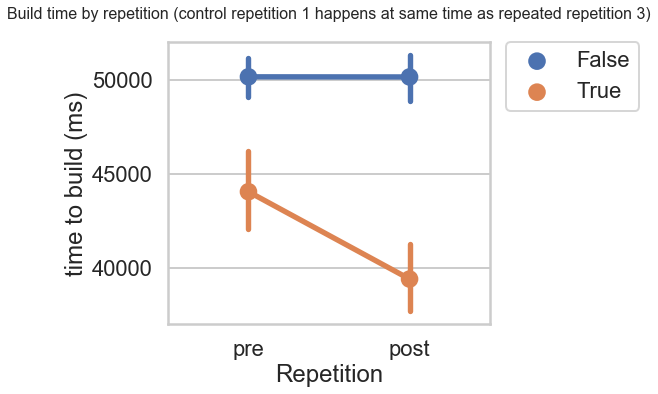

In [38]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='phase', 
                y='timeToBuild', 
                hue='perfectScore', 
                #kind='point', 
                #legend=False,
                data=df[df.phase.isin(['pre','post'])])
plt.ylabel('time to build (ms)')
plt.xlabel('Repetition')
plt.title('Build time by repetition (control repetition 1 happens at same time as repeated repetition 3)\n',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

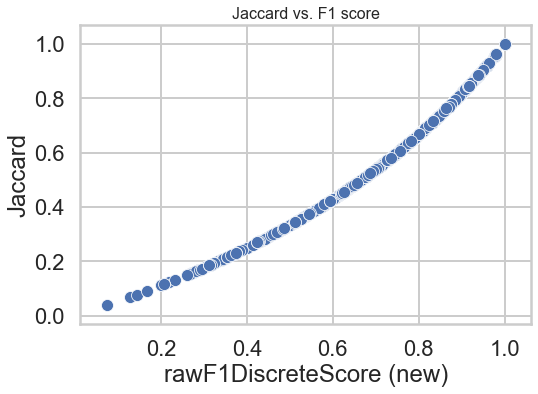

In [277]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                y='jaccardDiscrete', 
                #hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('Jaccard')
plt.xlabel('rawF1DiscreteScore (new)')
plt.title('Jaccard vs. F1 score',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()


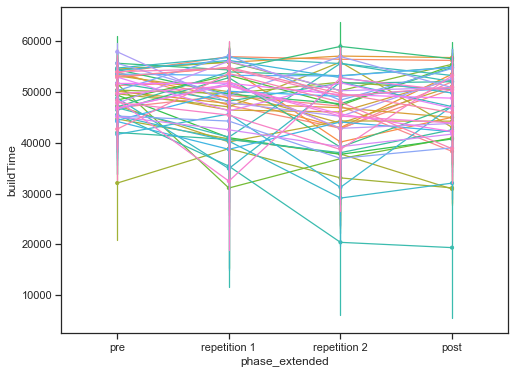

In [278]:
# Build Time over phase

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

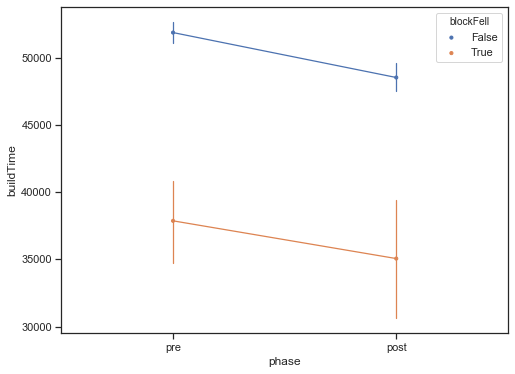

In [41]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

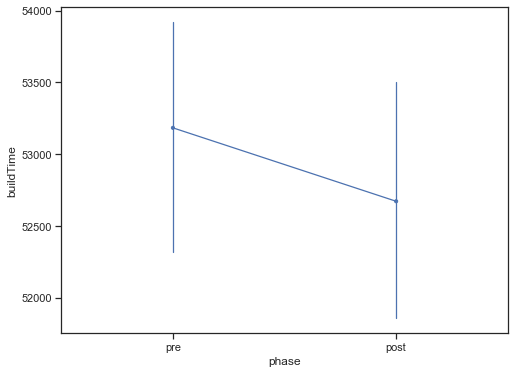

In [319]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  #hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[(df.phase.isin(['pre','post']))&(~df.blockFell)])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

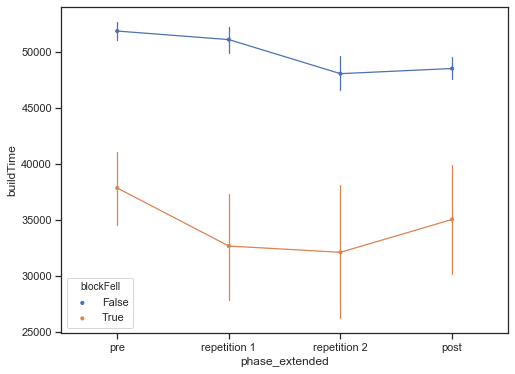

In [287]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


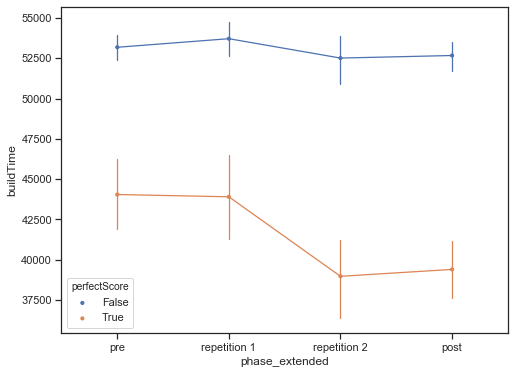

In [44]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[~df.blockFell])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


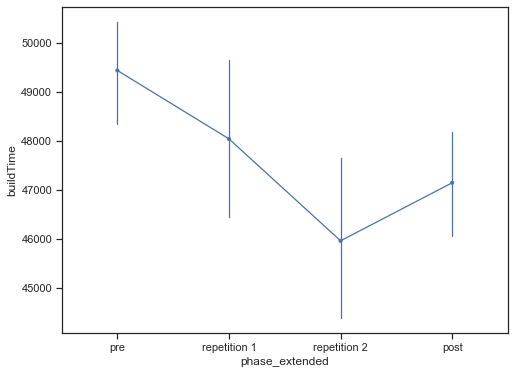

In [45]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  #hue='rawF1DiscreteScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


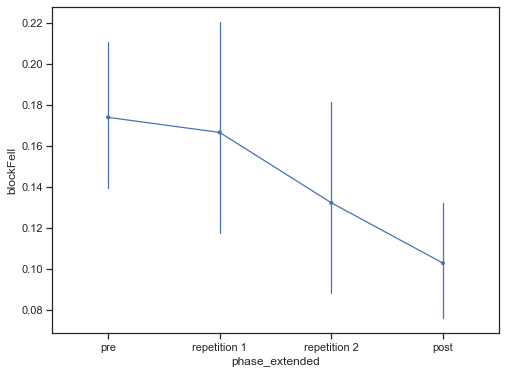

In [46]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(y='blockFell', 
                  x='phase_extended',
                  #kind='point', 
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


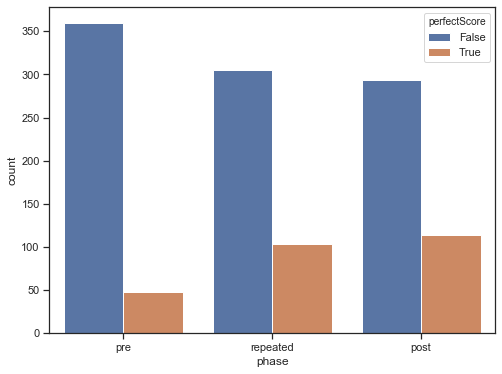

In [47]:
#perfect scores over time

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.countplot(x='phase', hue='perfectScore', data = df)

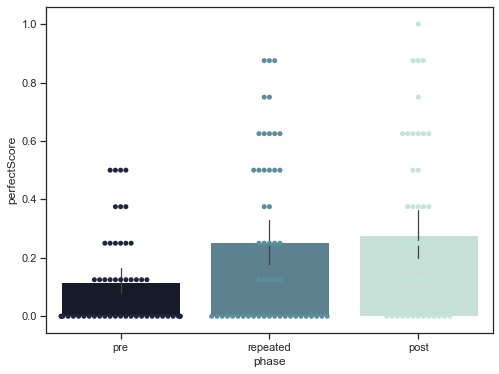

In [48]:
df_perfect_score_means = df.groupby(by=['gameID','phase'])['perfectScore'].agg(np.mean).reset_index()

#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.barplot(x='phase', 
                y='perfectScore', 
                order=['pre','repeated','post'],
                palette="ch:r=-.3,d=.1_r",
                data = df_perfect_score_means)
c = sns.swarmplot(x='phase', 
                    order=['pre','repeated','post'],
                    dodge=True,
                    y='perfectScore',
                    palette="ch:r=-.3,d=.15_r",
                    data = df_perfect_score_means)

In [49]:
df_perfect_score_means.groupby('phase_extended').perfectScore.value_counts()

KeyError: 'phase_extended'

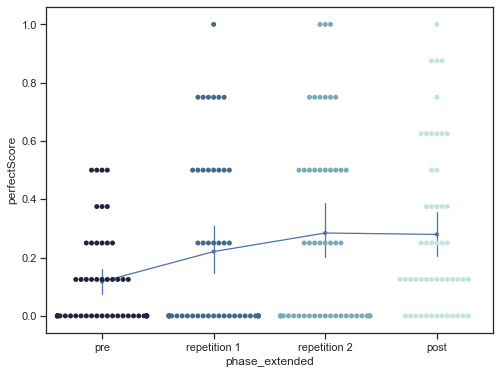

In [530]:
df_perfect_score_means = df.groupby(by=['gameID','phase_extended'])['perfectScore'].agg(np.mean).reset_index()

#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

c = sns.swarmplot(x='phase_extended', 
                    order=['pre','repetition 1','repetition 2','post'],
                    dodge=True,
                    y='perfectScore',
                    palette="ch:r=-.25,d=.15_r",
                    data = df_perfect_score_means)
c = sns.pointplot(x='phase_extended', 
                y='perfectScore', 
                order=['pre','repetition 1','repetition 2','post'],
                data = df_perfect_score_means)

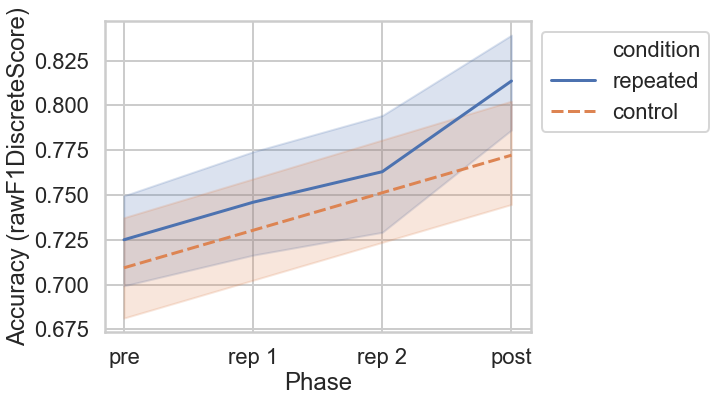

In [531]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df[~df.perfectScore]);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(.4,1,5))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

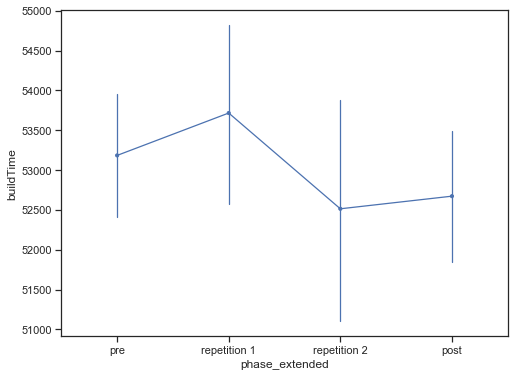

In [532]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[(~df.perfectScore)&(~df.blockFell)])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

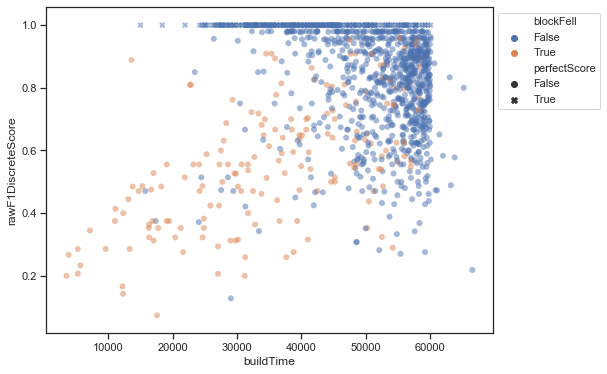

In [533]:
# Score by Build Time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='buildTime', 
                    y='rawF1DiscreteScore', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='blockFell',
                    linewidth=0,
                    #kind='point',
                    alpha=0.5,
                    data=df)
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

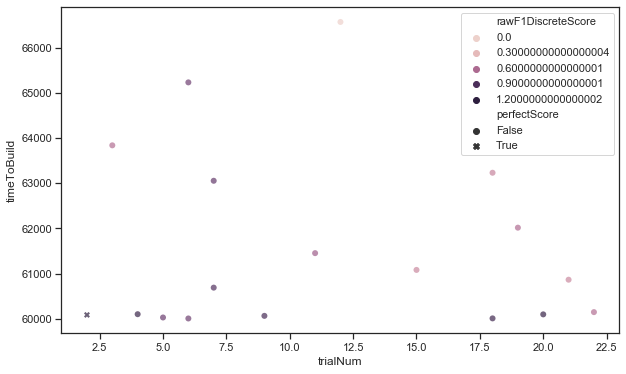

In [534]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='timeToBuild', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='rawF1DiscreteScore',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df[df.timeToBuild>60000])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

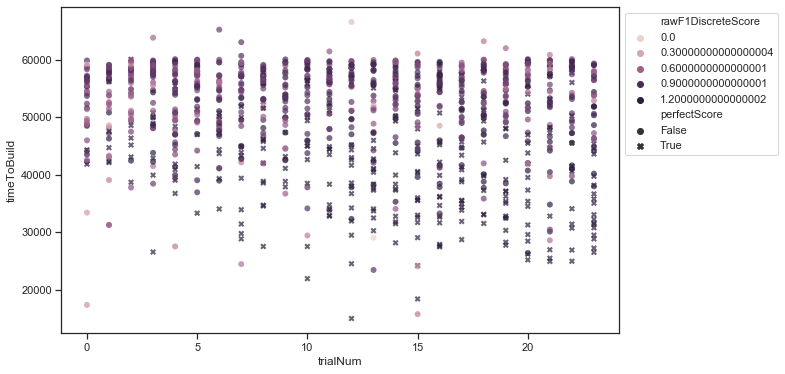

In [535]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='timeToBuild', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='rawF1DiscreteScore',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df[~df.blockFell])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

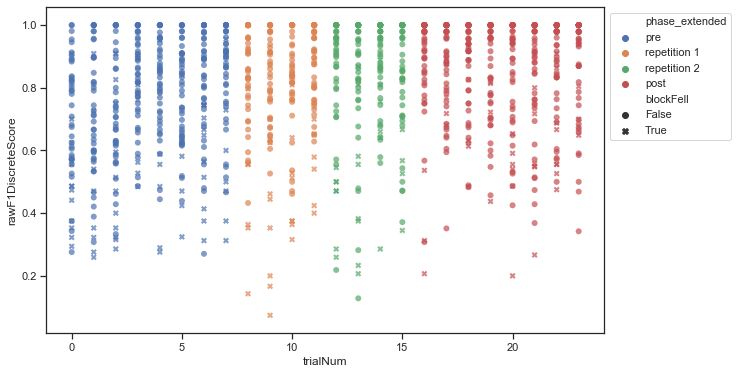

In [536]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='rawF1DiscreteScore', 
                    style='blockFell',
                    #size= 'numBlocks',
                    #sizes=(10,30),
                    hue='phase_extended',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df)
                    #data=df[~df.blockFell])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
dfs.groupby(by=['gameID','trialNum']).

## Block Distributions

Here we calculate the probability distributions of using certain block kinds (that is blocks of a certain dimension)

A: 1x2, B: 2x1, C: 2x2, D: 2x4, E: 4x2

In [537]:
#Helper functions

def probs(data):
    nBlocks = np.sum(data['blockKind'].value_counts())
    sums = data['blockKind'].value_counts()
    probs = (sums/nBlocks).sort_index().reset_index()
    return probs

def prob_list(data):
    nBlocks = np.sum(data['blockKind'].value_counts())
    sums = data['blockKind'].value_counts()
    probs = (sums/nBlocks).sort_index()
    return probs

def block_kind_plot(**kwargs):
    data = kwargs.pop("data")
    sns.barplot(x='index', 
                y='blockKind',
                #hue='condition', 
                ci=False,
                #kind='point', 
                #legend=False,
                data=probs(data),
                **kwargs)
    
    
def block_counts(data):
    sums = data['blockKind'].value_counts()
    return sums

In [ ]:
prob_list()

### Visualize distributions of block kind

Note that we would expect some difference between pre and post.
People place more blocks.
It is likely they are reaching higher parts of the structures, which will require a different distribution of blocks from the lower end of the structures.


Before normalizing- see if pre is subsumed by post. Using same blockkind distribution plus final blocks

In [ ]:
ppts = np.sort(df['gameID'].unique())
targets = np.sort(df['targetName'].unique())

block_counts(dfs[(dfs.gameID==ppts[0])&(dfs.targetName==targets[0])&(dfs.phase=='pre')])

In [ ]:
#for each structure
#for each participant
#take pre and post
#do they get more peaky?

target_1 = np.zeros(len(ppts))



In [ ]:
# pre vs post
f = sns.FacetGrid(dfs[dfs.phase.isin(['pre','post'])], col="phase")
g = f.map_dataframe(block_kind_plot, palette="GnBu")

In [ ]:
# Compare overall change in blockKind distributions.

f = sns.FacetGrid(dfs, col="phase", row="condition")
g = f.map_dataframe(block_kind_plot, palette="GnBu").add_legend()


In [ ]:
#Compare pre and post for individual structures

f = sns.FacetGrid(dfs[dfs.phase.isin(['pre','post'])], row="targetName", col='phase')
g = f.map_dataframe(blockKindPlot, palette="GnBu")

## Quantify difference: Earth Mover's (Wasserstein) Distance

In [ ]:
#Calculate Earth Mover's (Wasserstein) Distance between distributions of block kinds
#What is the difference pre and post?

pre_probs = prob_list(dfs[dfs.phase=='pre'])
post_probs = prob_list(dfs[dfs.phase=='post'])

stats.wasserstein_distance(pre_probs, post_probs)

How does this compare to difference between participants, and difference between structures?

In [ ]:
#What are the difference in distribution across participants?
ppts = np.sort(df['gameID'].unique())
ppt_probs = [prob_list(dfs[dfs.gameID==ppt]) for ppt in ppts]

ppt_dists = np.zeros((len(ppts),len(ppts)))

for i, ppt1 in enumerate(ppt_probs):
    for j, ppt2 in  enumerate(ppt_probs):
        ppt_dists[i,j] = stats.wasserstein_distance(ppt1, ppt2)

        
fig, ax = plt.subplots()
ax.imshow(ppt_dists)

In [ ]:
#What are the difference in distribution across structure?

targets = np.sort(df['targetName'].unique())
target_probs = [prob_list(dfs[dfs.targetName==target]) for target in targets]

target_dists = np.zeros((len(targets),len(targets)))

for i, target1 in enumerate(target_probs):
    for j, target2 in  enumerate(target_probs):
        target_dists[i,j] = stats.wasserstein_distance(target1, target2)
       
fig, ax = plt.subplots()
ax.imshow(target_dists)

In [ ]:
t = np.tril(target_dists).flatten()
p = np.tril(ppt_dists).flatten()
t_filt = t[t>0] #is there a better way to do this that won't remove genuine zero-distance values
p_filt = p[p>0] #is there a better way to do this that won't remove genuine zero-distance values
sns.distplot(t_filt, kde=True)
sns.distplot(p_filt, kde=True)

In [ ]:
# Are participants converging on a small set of solutions?
# Is there less between-subject variation in post compared to pre?

targets = np.sort(df['targetName'].unique())

pre_target_probs = [prob_list(dfs[(dfs.phase=='pre') & (dfs.targetName==target)]) for target in targets]
pre_target_dists = np.zeros((len(targets),len(targets)))
for i, target1 in enumerate(pre_target_probs):
    for j, target2 in  enumerate(pre_target_probs):
        pre_target_dists[i,j] = stats.wasserstein_distance(target1, target2)
        
post_target_probs = [prob_list(dfs[(dfs.phase=='post') & (dfs.targetName==target)]) for target in targets]
post_target_dists = np.zeros((len(targets),len(targets)))
for i, target1 in enumerate(post_target_probs):
    for j, target2 in  enumerate(post_target_probs):
        post_target_dists[i,j] = stats.wasserstein_distance(target1, target2)


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('pre')
ax.imshow(pre_target_dists)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('post')
ax.imshow(post_target_dists)



In [ ]:
dfs.columns

The distance between pre and post (0.013) is pretty small compared to between participants, or between structures

## Spatial Distribution

hand_selected_006


Text(0.5, 1.0, 'post, repeated')

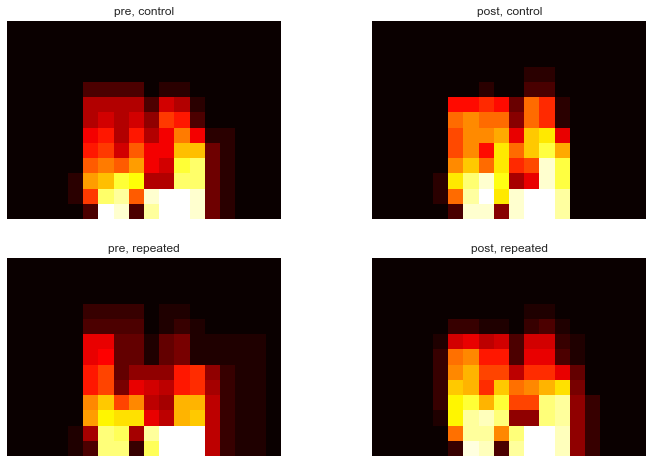

In [72]:
def showDiscreteMap(data, ax, vmax=None, **kwargs):
    world_maps = data.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
    av_map = np.add.reduce(np.array(world_maps))
    av_map = np.rot90(av_map)
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                **kwargs)
    else:
        ax.imshow(av_map,
                **kwargs)
    



targets = np.sort(df['targetName'].unique())
target= targets[2]
cmap= 'hot'

print(target)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2, 2, 1)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre') & (df.condition=='control')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('pre, control')

ax = fig.add_subplot(2, 2, 2)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='post') & (df.condition=='control')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('post, control')

ax = fig.add_subplot(2, 2, 3)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre') & (df.condition=='repeated')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('pre, repeated')

ax = fig.add_subplot(2, 2, 4)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='post') & (df.condition=='repeated')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('post, repeated')

#fig, ax = plt.subplots()
#showDiscreteMap(df[(df.targetName=='hand_selected_005') & (df.phase=='post')]['discreteWorld'], ax)

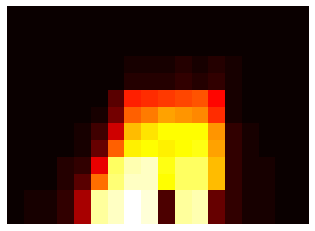

In [74]:
fig, ax = plt.subplots()
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld'], ax, cmap='hot')

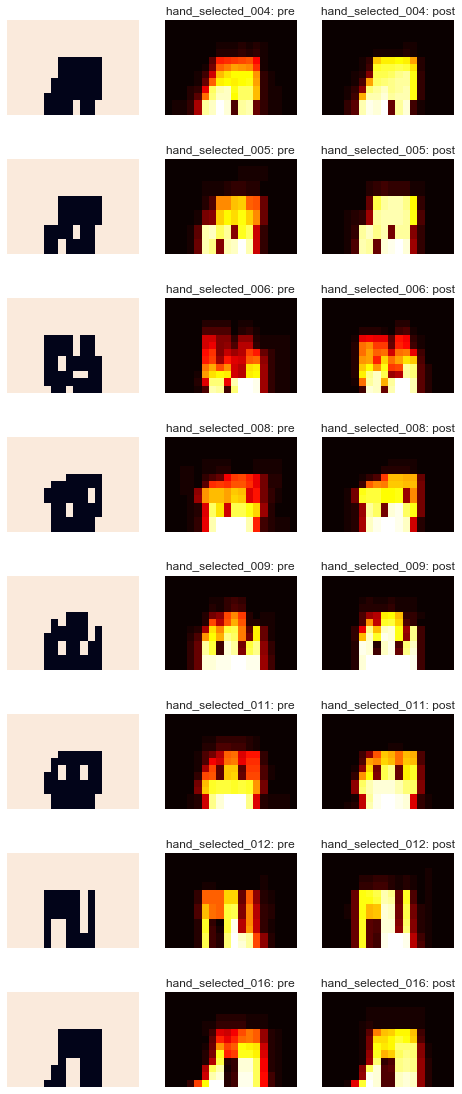

In [318]:
#Need to unnormalize these??

targets = np.sort(df['targetName'].unique())
cmap= 'hot'

fig = plt.figure(figsize=(8,20))
k=1

for i, target in enumerate(targets):
    
    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    silhouette = 1*(targetMaps[target])
    silhouette = np.rot90(silhouette)
    ax.imshow(silhouette)
    k+=1
    
    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld'], ax, cmap=cmap)
    ax.set_title(target + ': pre')
    k+=1

    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    showDiscreteMap(df[(df.targetName==target) & (df.phase=='post')]['discreteWorld'], ax, cmap=cmap)
    ax.set_title(target + ': post')
    k+=1
    
#4, 6, 9, 11

In [288]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

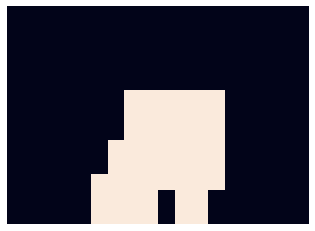

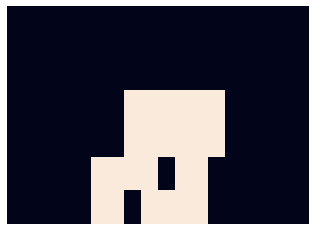

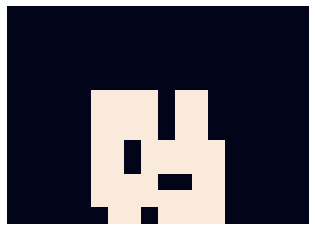

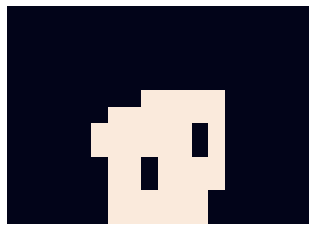

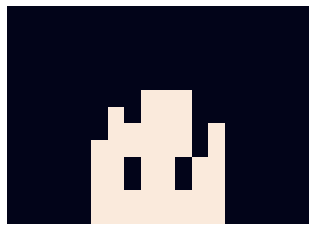

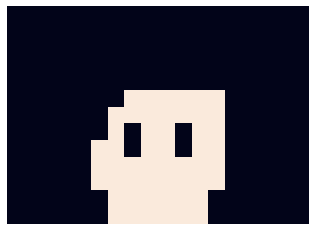

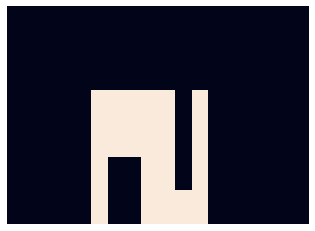

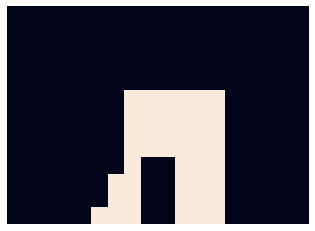

In [315]:
targets = np.sort(df['targetName'].unique())

for target in targets:
    fig, ax = plt.subplots()
    ax.axis('off')
    silhouette = 1*np.logical_not(targetMaps[target])
    silhouette = np.rot90(silhouette)
    ax.imshow(silhouette)

In [124]:
def getMeanIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.mean(ibis)

def getMedianIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.median(ibis)


def getSDIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.std(ibis)

def getMinIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.min(ibis)

In [125]:
dfi = dfi.drop_duplicates(subset=['gameID','trialNum','blockNum'], keep='last')

dfIBIMean = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMeanIBI).reset_index()
dfIBIMean = dfIBIMean.rename(columns = {'relativePlacementTime':'meanIBI'})
df = pd.merge(df, dfIBIMean, how='left', on=['gameID','trialNum'])

dfIBIMin = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMinIBI).reset_index()
dfIBIMin = dfIBIMin.rename(columns = {'relativePlacementTime':'minIBI'})
df = pd.merge(df, dfIBIMin, how='left', on=['gameID','trialNum'])

thinking_time = dfi[dfi.blockNum==1][['gameID','trialNum','relativePlacementTime']]
thinking_time = thinking_time.rename(columns = {'relativePlacementTime':'thinkingTime'})
df = pd.merge(df, thinking_time, how='left', on=['gameID','trialNum'])

In [137]:
dfIBIMedian = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMedianIBI).reset_index()
dfIBIMedian = dfIBIMedian.rename(columns = {'relativePlacementTime':'medianIBI'})
df = pd.merge(df, dfIBIMedian, how='left', on=['gameID','trialNum'])


In [138]:
dfIBISD = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getSDIBI).reset_index()
dfIBISD = dfIBISD.rename(columns = {'relativePlacementTime':'sdIBI'})
df = pd.merge(df, dfIBISD, how='left', on=['gameID','trialNum'])


ValueError: Invalid RGBA argument: masked

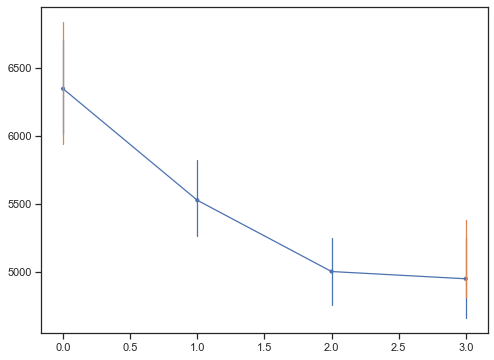

In [272]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='meanIBI', 
                  hue='condition',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='medianIBI', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

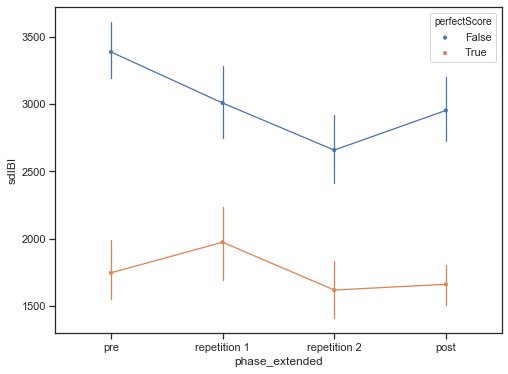

In [139]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='sdIBI', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

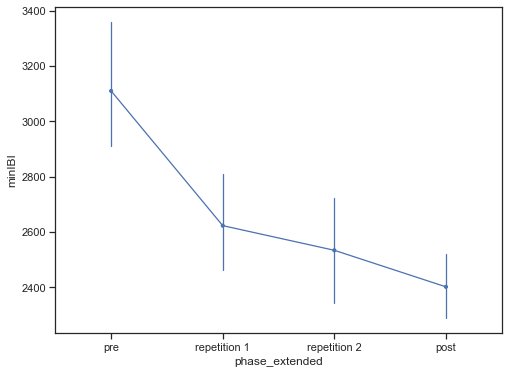

In [273]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='minIBI', 
                  #hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
df.columns

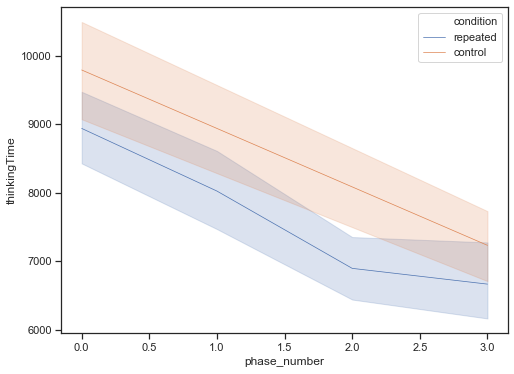

In [274]:
# Thinking time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.lineplot(x='phase_number', 
                  y='thinkingTime', 
                  #legend=False,
                  #kind='point', 
                  data=df)

In [ ]:
# Thinking time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                      y='build', 
                      hue='condition',
                      legend=False,
                      #kind='point', 
                      size = 0.3,
                      data=df)

## Block kind analysis including location

We want to see if people are placing the same blocks in the same location
So we should grab their first structure, find the location and type of each block.
And for each (blockKind,location) pair, see if the same exists in the final structure.

These heatmaps give a general sense of the changes in area covered from pre to post phases. However, they are insensitive to the particular strategies-- for example the specific block dimensions- that people used when building these structure. To quantify similarity between construction processes for the same structure, we compared where blocks of specific dimensions were placed.



In [207]:
dfig = dfi[dfi.targetName=='hand_selected_004'].groupby(['gameID','trialNum'])
#dfig.groups.keys()
trial_1 = dfig.get_group(('0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959', 5))
trial_1[['width_discrete','height_discrete','x_discrete','y_discrete']]




,width_discrete,height_discrete,x_discrete,y_discrete
30,2,2,6,0
31,4,2,1,0
32,4,2,1,2
33,4,2,2,4
34,4,2,3,6
35,2,4,6,2


In [230]:
trial_pre = dfi[(dfi.targetName=='hand_selected_005') & (dfi.gameID=='0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959')& (dfi.phase=='pre')]
trial_post = dfi[(dfi.targetName=='hand_selected_005') & (dfi.gameID=='0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959')& (dfi.phase=='post')]

a = trial_pre[['blockKind','x_discrete','y_discrete']]
a

,blockKind,x_discrete,y_discrete
6,D,7,0
7,D,0,0
8,C,5,0
9,E,0,4


In [231]:
b = trial_post[['blockKind','x_discrete','y_discrete']]
b

,blockKind,x_discrete,y_discrete
143,D,7,0
144,E,3,0
145,A,3,2
146,C,7,4
147,D,0,0
148,E,0,4
149,D,2,6


In [324]:
# for each (k/x/y) 4tuple in pre, look for matching in post
#If matching --> ?
# either just count matching?
# or get the set difference (missing plus extra)
# number of matching minus set diff?

a.apply(lambda row: row[['blockKind','x_discrete','y_discrete']].isin(b), axis=1)

,blockKind,x_discrete,y_discrete
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [325]:
for index, row in a.iterrows():
    print(b[(b.blockKind == row['blockKind']) & 
            (b.x_discrete == row['x_discrete']) & 
            (b.y_discrete == row['y_discrete'])].shape[0])

1
1
0
1


In [504]:
def prop_unchanged(a_blocks, b_blocks):
    '''
    Given two dataframes a_blocks and b_blocks of block placements, 
    return the proportion of block placements in a_blocks that are also in b_blocks
    '''
    same = []
    for index, a in a_blocks.iterrows():
        same.append(b_blocks[(b_blocks.blockKind == a['blockKind']) & 
            (b_blocks.x_discrete == a['x_discrete']) & 
            (b_blocks.y_discrete == a['y_discrete'])].shape[0])
    proportion = np.mean(same)
    return proportion

def compare_pre_post(rows):
    pre_blocks = rows[rows.phase=='pre']
    post_blocks = rows[rows.phase=='post']
    return prop_unchanged(pre_blocks,post_blocks)

def compare_reps(rows, rep_a, rep_b):
    pre_blocks = rows[rows.repetition==rep_a]
    post_blocks = rows[rows.repetition==rep_b]
    return prop_unchanged(pre_blocks,post_blocks)

In [477]:
dfi_prop_unchanged_grouped = dfi[dfi.phase.isin(['pre','post'])].groupby(by=['gameID','targetName']).apply(compare_pre_post)
dfi_prop_unchanged = dfi_prop_unchanged_grouped.reset_index().rename(columns={0: "prop_unchanged"})

In [478]:
d = pd.merge(df, dfi_prop_unchanged, how='left', on=['gameID','targetName'])
d2 = d[d.phase=='pre']

(array([100.,  33.,  74.,  30.,  26.,  48.,  24.,  31.,  20.,  22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

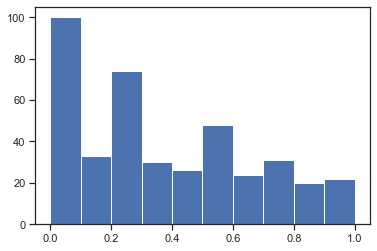

In [479]:
plt.hist(x='prop_unchanged',
         data=dfi_prop_unchanged)

(array([2., 1., 6., 9., 7., 6., 7., 8., 3., 2.]),
 array([0.015625  , 0.0831184 , 0.15061179, 0.21810519, 0.28559858,
        0.35309198, 0.42058537, 0.48807877, 0.55557216, 0.62306556,
        0.69055895]),
 <a list of 10 Patch objects>)

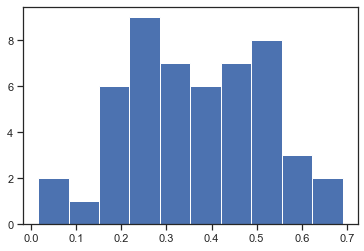

In [480]:
ppt_prop_changed = dfi_prop_unchanged.groupby('gameID').apply(np.mean)
plt.hist(x='prop_unchanged',
         data=ppt_prop_changed)

(array([48., 16., 38., 16., 12., 28.,  9., 19., 10.,  8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

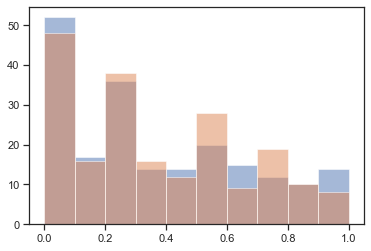

In [481]:
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='repeated'])
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='control'])

(array([17., 11., 26., 18., 17., 24., 15., 25., 18., 21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

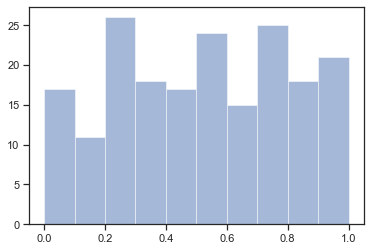

In [482]:
d = pd.merge(df, dfi_prop_unchanged, how='left', on=['gameID','targetName'])
d2 = d[d.phase=='pre']
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.rawF1DiscreteScore>0.8])
#plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='control'])

In [512]:
# For each ppt
# 8 pre scores- sort
# 2,2,2,2
# Each has % reuse
# Average those 2
# Each of those quartile goes in a bar

d2_quartile = d2.groupby('gameID').apply(\
    lambda x: x.sort_values('rawF1DiscreteScore').assign(f1_quartile=[1,1,2,2,3,3,4,4]))\
    .reset_index(drop=True)

prop_quartiles = d2_quartile.groupby(['gameID','f1_quartile'])['prop_unchanged'].apply(np.mean).reset_index()

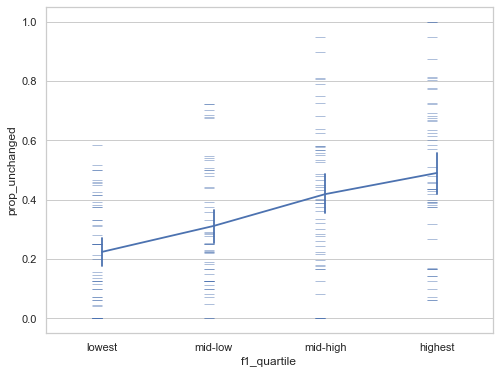

In [647]:
fig = plt.figure(figsize=(8,6))
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
sns.set_style('whitegrid', {'legend.frameon':False})
sns.scatterplot(x = 'f1_quartile', 
            y = 'prop_unchanged', 
            #jitter=0, 
            alpha = 0.6, 
            palette = pal,
            marker = 0,
            s = 100,
            data=prop_quartiles)
sns.pointplot(x='f1_quartile',
              y='prop_unchanged',
              alpha = 0.8,
              markers = [""],
              data = prop_quartiles)


In [517]:
prop_quartiles.loc[prop_quartiles.f1_quartile == 1,'f1_quartile'] = 'lowest'
prop_quartiles.loc[prop_quartiles.f1_quartile == 2, 'f1_quartile'] = 'mid-low'
prop_quartiles.loc[prop_quartiles.f1_quartile == 3, 'f1_quartile'] = 'mid-high'
prop_quartiles.loc[prop_quartiles.f1_quartile == 4, 'f1_quartile'] = 'highest'
prop_quartiles
out_path = os.path.join(csv_dir,'block_silhouette_placement_quartiles_{}.csv'.format('Exp2Pilot3'))
prop_quartiles.to_csv(out_path)

In [ ]:
dfi[dfi.phase.isin(['pre','post'])]

## Between repeatition 2 and 3

In [505]:
rdfi_prop_unchanged_grouped = dfi[(dfi.repetition>=2)].groupby(by=['gameID','targetName']).apply(lambda x: compare_reps(x, 2, 3))
rdfi_prop_unchanged = rdfi_prop_unchanged_grouped.reset_index().rename(columns={0: "prop_unchanged"})

(array([28., 22., 18., 18.,  9., 34., 19., 17., 19., 20.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

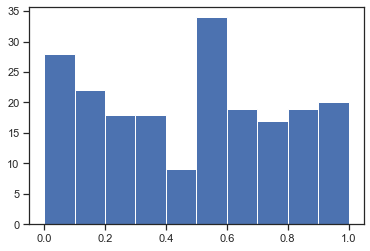

In [506]:
plt.hist(x='prop_unchanged',
         data=rdfi_prop_unchanged)

In [501]:
rd = pd.merge(df, rdfi_prop_unchanged, how='left', on=['gameID','targetName'])
rd2 = rd[rd.repetition==2]

In [502]:
rd2_quartile = rd2.groupby('gameID').apply(\
    lambda x: x.sort_values('rawF1DiscreteScore').assign(f1_quartile=[1,2,3,4]))\
    .reset_index(drop=True)

#prop_quartiles = d2_quartile.groupby(['gameID','f1_quartile'])['prop_unchanged'].apply(np.mean).reset_index()

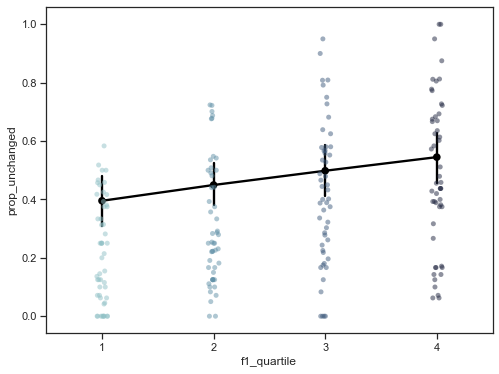

In [503]:
fig = plt.figure(figsize=(8,6))
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
sns.set(style="ticks", rc={"lines.linewidth": 1.3})
sns.stripplot('f1_quartile', 'prop_unchanged', jitter=0.05,alpha = 0.5, palette=pal, data=prop_quartiles)
sns.pointplot(x='f1_quartile',
              y='prop_unchanged',
              color='black',
              data = rd2_quartile)

In [ ]:
sns.swarmplot